In [229]:
import os
import matplotlib.pyplot as plt
import numpy as np

import TimeTag
import Visibility_OTPS as visnew
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit



#### Parameters 

In [231]:
ch_det = 2 # Channel for single photon detector
ch_AWG = 0 # Channel for AWG trigger
ch_piezo = 3 # Channel for piezo trigger

t_integration = 30 # Integration time for measurement

### Save Data (time tags)

In [107]:
os.chdir('c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\')
os.getcwd()

'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General'

In [232]:
filename, d = TimeTag.save_timetags(ch_det, ch_AWG, ch_piezo,t_integration)

c:\Users\LocalAdmin\Imperial College London\UQOG Quantum Memories - PH - General
155558




### Import Data

In [109]:
folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-11_TimeBinQubit\\'
filename = folder + os.sep + '2024-03-11_105335.ttbin'

channels, timestamps = TimeTag.load_tt_data(filename)

In [110]:
print(channels)
print(timestamps)

len(timestamps)

[2. 2. 2. ... 0. 2. 0.]
[1.26678634e+12 1.26678650e+12 1.26678660e+12 ... 3.12037120e+13
 3.12037124e+13 3.12037140e+13]


49843681

In [111]:
times_AWG = timestamps[np.where(channels==ch_AWG)[0]]
average_AWG_duration = np.mean(np.diff(times_AWG))
AWG_rate = 1/(average_AWG_duration*1e-12)
print('AWG rep rate = ', AWG_rate)

laser_rep = AWG_rate*160
pulse_separation = 1/laser_rep * 4 * 10**9

print('Laser rep rate = ', laser_rep)
print('AWG duration in ns = ', average_AWG_duration)
print('Pulse separation time in ns = ', pulse_separation)

AWG rep rate =  500829.9559644562
Laser rep rate =  80132792.954313
AWG duration in ns =  1996685.677625421
Pulse separation time in ns =  49.917141940635524


In [112]:
binwidth = 100 # histogram bin width in ps
n_bins = int(2000000/binwidth)
# t_hist, counts_hist = vis.build_histogram(channels,timestamps, ch_AWG, ch_det,binwidth,laser_rep,n_bins )
# t_hist, counts_hist_list, time_bin_list = visnew.build_histogram(channels,timestamps, ch_AWG, ch_det,binwidth,laser_rep,n_bins)

# Return a list with each element corresponding to the detections of 25 AWG triggers
time_bin_list = visnew.detection_binning(channels,timestamps, ch_AWG)

# Get mean number of detections per AWG trigger
total_det = 0
for time in time_bin_list:
    total_det += len(time)
    mean_det = total_det/len(time_bin_list)

print('Mean number of detections per AWG trigger = ', mean_det/25)



# Note that the time axis is incorrect. Distance of early pulses is 500. If time is given in ps then this should rather be 50*1000=50000.

Mean number of detections per AWG trigger =  2.324395163172884


Number of pulses in integration time =  20033
Number of 50us unit bins in integration time =  20
Integration time in ms =  1.0


100%|██████████| 18/18 [00:00<00:00, 9002.80it/s]


Text(0.5, 1.0, 'Histogram of raw data with bin size 20000')

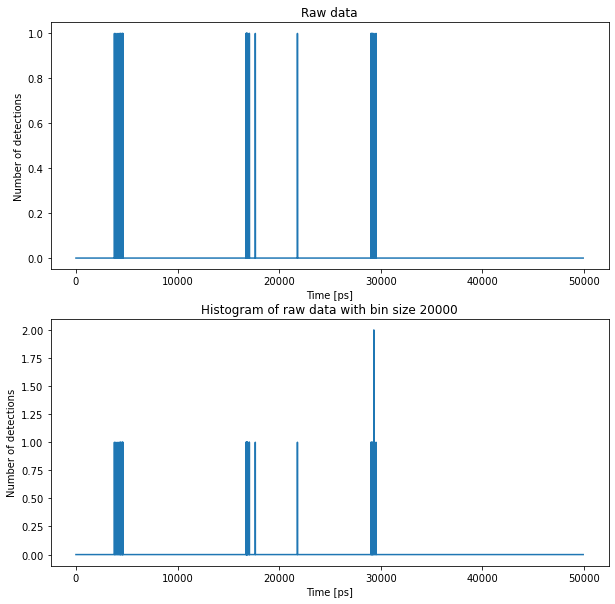

In [225]:
# Take a look at the time binning for the first integration bin, e.g first ms
integration_time = 1000000000 # in ps
num_pulses = int(integration_time/(pulse_separation*1000))
num_unit_bins = int(integration_time/(50*10**6))
print('Number of pulses in integration time = ', num_pulses)
print('Number of 50us unit bins in integration time = ', num_unit_bins)
print('Integration time in ms = ', integration_time/10**9)

concatenated_time_bin = time_bin_list[0]
for i in tqdm(range(1,num_unit_bins-1)):
    concatenated_time_bin = np.concatenate((concatenated_time_bin, time_bin_list[i]))

# n denotes the nth 50ns time window, i.e. the nth pulse
n = 0
clipped_time_bin = concatenated_time_bin[(concatenated_time_bin > pulse_separation*1000*n) & (concatenated_time_bin <= pulse_separation*1000*(n+1))]

# Look at raw data
fig, ax = plt.subplots(2,1,figsize=(10,10))
time_array = np.arange(int(n*pulse_separation*1000), int((n+1)*pulse_separation*1000), 1)
count_array = np.zeros_like(time_array)
for i, t in enumerate(time_array):
    count_array[i] = np.sum(clipped_time_bin == t)
ax[0].plot(time_array, count_array)
ax[0].set_xlabel('Time [ps]')
ax[0].set_ylabel('Number of detections')
ax[0].set_title('Raw data')


# counts, bins = np.histogram(clipped_time_bin, bins=n_bins)
# # counts, bins = np.histogram(concatenated_time_bin, bins=n_bins)
# ax[1].plot(bins[:-1], counts)
# ax[1].set_xlabel('Time [ps]')
# ax[1].set_ylabel('Number of detections')

counts, bins = np.histogram(clipped_time_bin, bins=n_bins, range=(int(n*pulse_separation*1000), int((n+1)*pulse_separation*1000)))
ax[1].plot(bins[:-1], counts)
ax[1].set_xlabel('Time [ps]')
ax[1].set_ylabel('Number of detections')
ax[1].set_title(f'Histogram of raw data with bin size {n_bins}')


In [187]:
def get_interference_amplitude(time_bin_list, n_bins, start_bin, end_bin, integration_time, precision=0.1, plot=True, print_res=True):
    """
    Function to calculate the amplitude of the interference pattern in the time bin data.
    
    Parameters:
    time_bin_list: list of lists
        List of time bins with detections
    n_bins: int
        Number of bins in the histogram
    start_bin: int
        Start bin of integration time
    end_bin: int
        End bin of integration time
    integration_time: int
        Integration time in ps
    precision: float
        Precision of the peak finding algorithm
    plot: bool
        If True, plot the histogram
    print_res: bool
        If True, print the results
    
    Returns:
    count_total: array
        Array of counts in the histogram
    interference_amplitude: float
        Amplitude of the interference pattern
    
    
        """

    if start_bin > end_bin:
        raise ValueError('Start bin must be smaller than end bin')
    
    bin_difference_integration_time = int(integration_time/(50*10**6))

    if end_bin-start_bin != bin_difference_integration_time:
        raise ValueError('Integration time must be correspond to the time span of start and end bin')


    concatenated_time_bin = time_bin_list[start_bin]
    for i in range(start_bin+1,end_bin):
        concatenated_time_bin = np.concatenate((concatenated_time_bin, time_bin_list[i]))

    trident_list = []

    for i in range(bin_difference_integration_time):
        clipped_time_bin = concatenated_time_bin[(concatenated_time_bin > pulse_separation*1000*i) & (concatenated_time_bin < pulse_separation*1000*(i+1))]
        trident_list.append(clipped_time_bin)

    count_list = []
    bin_list = []
    for i, trident in enumerate(trident_list):
        counts, bins = np.histogram(trident, bins=n_bins, range=(int(i*pulse_separation*1000), int((i+1)*pulse_separation*1000)))
        count_list.append(counts)
        bin_list.append(bins)

    count_total = 0
    for count in count_list:
        count_total += count

    peaks, _ = find_peaks(count_total, height=max(count_total)/20, distance=4000)
    peaks = peaks.tolist()

    if len(peaks) != 3:
        if len(peaks) == 2:
            # print('Warning: Number of peaks is 2')
            if peaks[0] > 2000:
                # print('Warning: Early peak not found')
                peaks.insert(0, 1700)
            if peaks[1] < 8000:
                # print('Warning: Late peak not found')
                peaks.append(11600)
            if peaks[0] < 2000 and peaks[1] > 8000:
                # print('Warning: Interference peak not found')
                peaks.insert(1, 6500)
            
        if len(peaks) == 1:
            # print('Warning: Number of peaks is 1')
            if peaks[0] > 2000 and peaks[0] < 8000:
                # print('Warning: Only interference peak found')
                peaks.insert(0, 1700)
                peaks.append(11600)
            if peaks[0] < 2000:
                # print('Warning: Only early peak found')
                peaks.append(6500)
                peaks.append(11600)
            if peaks[0] > 8000:
                # print('Warning: Only late peak found')
                peaks.insert(1, 6500)
                peaks.insert(0, 1700)

        if len(peaks) > 3:
            # print('Warning: Number of peaks is more than 3')
            peaks = peaks[:3]

    early_region = count_total[peaks[0]-int(n_bins*precision):peaks[0]+int(n_bins*precision)]
    late_region = count_total[peaks[2]-int(n_bins*precision):peaks[2]+int(n_bins*precision)]
    interference_region = count_total[peaks[1]-int(n_bins*precision):peaks[1]+int(n_bins*precision)]
    interference_amplitude = np.sum(interference_region)
    early_amplitude = np.sum(early_region)
    late_amplitude = np.sum(late_region)

    # Convert peaks to time
    peaks = [bin_list[0][peaks[0]], bin_list[0][peaks[1]], bin_list[0][peaks[2]]]
    
    if print_res:
        print(f'Early peak at {peaks[0]} with amplitude {early_amplitude}')
        print(f'Interference peak at {peaks[1]} with amplitude {interference_amplitude}')
        print(f'Late peak at {peaks[2]} with amplitude {late_amplitude}')



    if plot:
        plt.plot(bin_list[0][:-1], count_total)
        
        plt.vlines(peaks[0]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[0]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]-int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]+int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))

        plt.xlabel('Time [ps]')
        plt.ylabel('Number of detections')

        plt.title(f"Trident peaks for integration time {integration_time/10**9} ms")


    return count_total, interference_amplitude, early_amplitude, late_amplitude

Number of unit bins =  20
Early peak at 4392.696 with amplitude 214
Interference peak at 16699.73235 with amplitude 432
Late peak at 29111.594399999998 with amplitude 187
Interference amplitude =  432


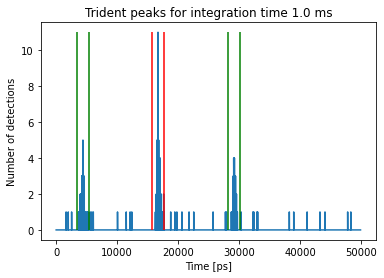

In [219]:
num_unit_bins = int(integration_time/(50*10**6)) # Number of 50us unit bins in integration time
print('Number of unit bins = ', num_unit_bins)
n=0


# Overlay all tridents in the integration time and output the interference amplitude
count_total, interference_amplitude, early_amplitude, late_amplitude = get_interference_amplitude(time_bin_list, n_bins, n*num_unit_bins, (n+1)*num_unit_bins, integration_time, precision=0.05, plot=True, print_res=True)
print('Interference amplitude = ', interference_amplitude)




In [116]:
# Sanity check

# Number of 25*2 us long bins
len(time_bin_list)
total_exp_time = len(time_bin_list)*25*2*10**(-6)
print('Total experimental time in seconds = ', total_exp_time)

# Compare to timestamps
total_exp_time_tt = (timestamps[-1]-timestamps[0])*10**(-12)
print('Total experimental time in seconds (timestamps) = ', total_exp_time_tt)

# Discrepancy
print('Discrepancy between experimental time and timestamps = ', total_exp_time-total_exp_time_tt)


Total experimental time in seconds =  29.9866
Total experimental time in seconds (timestamps) =  29.936927619608
Discrepancy between experimental time and timestamps =  0.04967238039199984


Number of ms bins, i.e. number of interference mmt =  29986


  0%|          | 4/29985 [00:00<14:06, 35.42it/s]

100%|██████████| 29985/29985 [04:49<00:00, 103.47it/s]


Text(0.5, 0, 'Bin in 0.001 seconds')

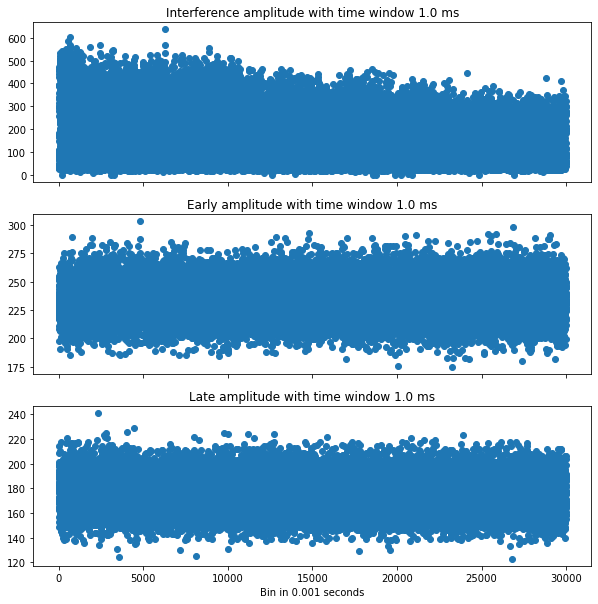

In [226]:
interference_amplitude_list = []
early_amplitude_list = []
late_amplitude_list = []

# Number of unit bin each 50us in ms integration time
num_unit_bins = int(integration_time/(50*10**6))

# Number of interference mmt
ms_bins = int(len(time_bin_list)*50*10**(-3)/(integration_time/10**9))
print('Number of ms bins, i.e. number of interference mmt = ', ms_bins)

for i in tqdm(range(0, ms_bins-1)):
    count_list, interference_amplitude, early_amplitude, late_amplitude = get_interference_amplitude(time_bin_list, n_bins, i*num_unit_bins, (i+1)*num_unit_bins, integration_time, precision=0.02, plot=False, print_res=False)
    interference_amplitude_list.append(interference_amplitude)
    early_amplitude_list.append(early_amplitude)
    late_amplitude_list.append(late_amplitude)

# Plot time evolution of interference amplitude in ms bins
ms_bin_array = np.arange(0,ms_bins-1,1)

# ms_bin_array in time units


fig, ax = plt.subplots(3,1,figsize=(10,10), sharex=True)
ax[0].scatter(ms_bin_array, interference_amplitude_list)
ax[0].set_title(f'Interference amplitude with time window {integration_time/10**9} ms')
# ax[0].set_xlim(0,100)
ax[1].scatter(ms_bin_array, early_amplitude_list)
ax[1].set_title(f'Early amplitude with time window {integration_time/10**9} ms')
# ax[1].set_xlim(0,100)
ax[2].scatter(ms_bin_array, late_amplitude_list)
ax[2].set_title(f'Late amplitude with time window {integration_time/10**9} ms')
ax[2].set_xlabel(f'Bin in {integration_time/(10**(12))} seconds')
# ax[2].set_xlim(0,100)



Fitted Amplitude: -191.82830417056473
Fitted Frequency [Hz]: 97.80454506739677
Fitted Phase: -0.22829299749409737
Visibility for time window 1.0 ms =  0.8842975206611571


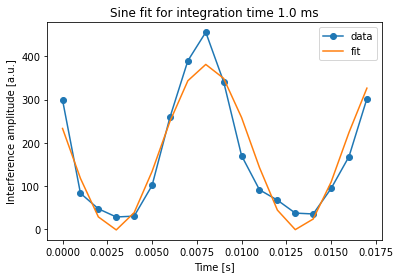

In [228]:


time_array = ms_bin_array*(integration_time/10**9)/10**3 # Time in seconds


def fit_sine(interference_amplitude_list, time_array, slice):

    # Get values of interference amplitude for time_array 0-0.1s
    slice_interference = interference_amplitude_list[np.where(time_array > slice[0])[0][0]:np.where(time_array < slice[1])[0][-1]]

    # Define the sine function
    def sine_func(x, amplitude, frequency, phase, setoff):
        return amplitude * np.sin(2 * np.pi * frequency * x + phase) + setoff 

    # Fit the sine function to the data
    x_data = time_array[:len(slice_interference)]
    y_data = slice_interference



    # Initial guess for the parameters
    initial_guess = [np.max(slice_interference), 100, 0, 300]

    # Perform the curve fit
    params, _ = curve_fit(sine_func, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, frequency_fit, phase_fit, setoff_fit = params

    # Print the fitted parameters
    print("Fitted Amplitude:", amplitude_fit)
    print("Fitted Frequency [Hz]:", frequency_fit)
    print("Fitted Phase:", phase_fit)

    plt.plot(x_data, y_data, 'o-', label='data')
    plt.plot(x_data, sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit), label='fit')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Interference amplitude [a.u.]')
    plt.title(f'Sine fit for integration time {integration_time/10**9} ms')

    return x_data, y_data, frequency_fit


def visibility(interference_amplitude_list, time_array, slice):
    slice_interference = interference_amplitude_list[np.where(time_array > slice[0])[0][0]:np.where(time_array < slice[1])[0][-1]]
    visibility = (np.max(slice_interference) - np.min(slice_interference))/(np.max(slice_interference) + np.min(slice_interference))
    return visibility

x_data, y_data, frequency_fit = fit_sine(interference_amplitude_list, time_array, [0,0.02])
print(f'Visibility for time window {integration_time/10**9} ms = ', visibility(interference_amplitude_list, time_array, [0,0.02]))





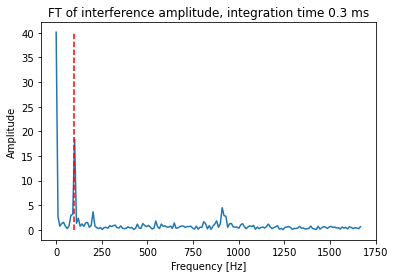

In [217]:
# Run FT on x_data, y_data
# Number of sample points
N = len(x_data)

# sample spacing
T = x_data[1]-x_data[0]

# Run FT
yf = fft(y_data)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Plot FT
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title(f'FT of interference amplitude, integration time {integration_time/10**9} ms')
# plt.xlim(0, 200)
ax.vlines(frequency_fit, colors='r', linestyles='--', ymin=0, ymax=max(2.0/N * np.abs(yf[0:N//2]))) 
plt.show()

In [10]:
binwidth = 100
ch_det = 2 # Channel for single photon detector
ch_AWG = 0 # Channel for AWG trigger
ch_piezo = 3 # Channel for piezo trigger

num_time_windows = 1
starting_scan_number = 1 
num_piezo_scans_to_av = 20
num_phase_bins = 21
t_offset = 55*1000 
pulse_duration = 7*1000
# laser_rep = 80132791.98692285

# sum_early_bin, sum_interference_bin, sum_late_bin = 
sum_ROIs,hist_t,hist_y = vis.vis_piezo_scan(channels,timestamps,ch_piezo,ch_det,ch_AWG,binwidth,num_time_windows,num_piezo_scans_to_av, num_phase_bins,t_offset,pulse_duration,laser_rep)

# vis_piezo_scan(channels,times,ch_piezo,ch_det,ch_AWG,binwidth,num_time_windows, num_piezo_scans_to_av, num_phase_bins,t_offset,pulse_duration):
    

[[515. 585.]]


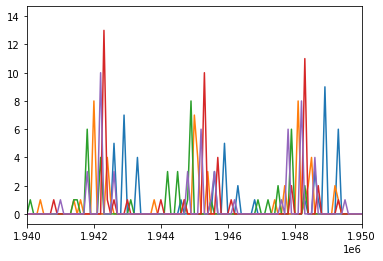

In [16]:
for i in range(5):
    # for j in range(20):
        plt.plot(hist_t[0,i,:],hist_y[0,i,:])
plt.xlim(1.94e6,1.95e6)
plt.show()

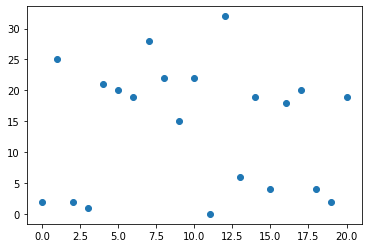

In [54]:

plt.plot(sum_ROIs[0,0,:],'o')
plt.show()
    # plt.plot(sum_ROIs[1,i,:],'o')


In [46]:
np.sqrt(300)/300

0.05773502691896258

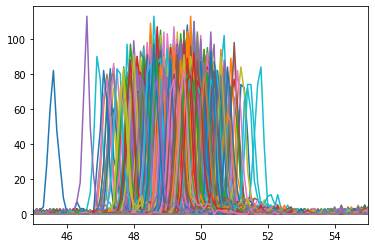

In [32]:
for i in range(21):
    for j in range(98):
        plt.plot(hist_t[j,i,:]/1000,hist_y[j,i,:])
plt.xlim(45,55)
plt.show()